In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Data Preprocessing

In [ ]:
# Load the dataset
data = pd.read_csv('/content/sample_data/household_power_consumption.txt', delimiter=';', parse_dates=[[0, 1]], infer_datetime_format=True, na_values='?', low_memory=False)

# List of columns to convert
columns_to_convert = ['Global_active_power', 'Global_reactive_power',
                      'Voltage', 'Global_intensity',
                      'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Convert columns to float64 using pd.to_numeric
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Check the data types to confirm the conversion
print(data.dtypes)


<ipython-input-37-ab6e0d2191e0>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv('/content/sample_data/household_power_consumption.txt', delimiter=';', parse_dates=[[0, 1]], infer_datetime_format=True, na_values='?', low_memory=False)
<ipython-input-37-ab6e0d2191e0>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/content/sample_data/household_power_consumption.txt', delimiter=';', parse_dates=[[0, 1]], infer_datetime_format=True, na_values='?', low_memory=False)
<ipython-input-37-ab6e0d2191e0>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirs

Date_Time                datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object


In [ ]:
data.isna().sum()

,0
Date_Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [ ]:
# Fill missing values
data.interpolate(method='linear', inplace=True)


In [ ]:
data.isna().sum()

,0
Date_Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
hour,0
day_of_week,0


## Feature Engineering, Modelling, Scaling for Linear Regression

In [ ]:

# Feature engineering: extract date features
data['Date_Time'] = pd.to_datetime(data['Date_Time'])
data['hour'] = data['Date_Time'].dt.hour
data['day_of_week'] = data['Date_Time'].dt.dayofweek

# Define predictors and target
X = data[['Global_reactive_power', 'Voltage', 'Global_intensity',
          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week']]
y = data['Global_active_power']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross-validation for Linear Regression
cv_scores = cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=5)  # Using 5 folds

# Print cross-validation results
print("CV Average R^2: {:.2f}".format(np.mean(cv_scores)))
print("CV Standard Deviation: {:.2f}".format(np.std(cv_scores)))

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Performance Metrics
print("Linear Regression R^2: {:.2f}".format(r2_score(y_test, y_pred_lr)))
print("Linear Regression MSE: {:.2f}".format(mean_squared_error(y_test, y_pred_lr)))

CV Average R^2: 1.00
CV Standard Deviation: 0.00
Linear Regression R^2: 1.00
Linear Regression MSE: 0.00


## Correlation Matrix to identify problematic column

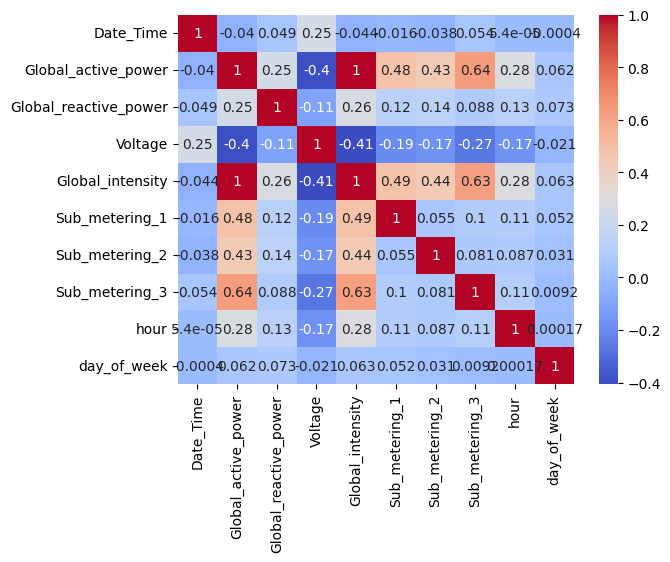

In [ ]:
import seaborn as sns

# Calculate correlations
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


## Linear Regression after identifying error

In [ ]:
# Remove 'Global_intensity' from predictors to prevent data leakage
X = data[['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week']]

# Proceed with data splitting, scaling, and model fitting as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model and evaluate
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Print updated performance metrics
print("Updated Linear Regression R^2: {:.2f}".format(r2_score(y_test, y_pred_lr)))
print("Updated Linear Regression MSE: {:.2f}".format(mean_squared_error(y_test, y_pred_lr)))


Updated Linear Regression R^2: 0.75
Updated Linear Regression MSE: 0.27


## Ridge Regression

In [ ]:
# 2. Ridge Regression
alphas = np.logspace(-6, 6, 100)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', store_cv_results=True)
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("\nRidge Regression")
print("-----------------")
print(f"Best alpha: {ridge_cv.alpha_}")
print(f"R^2 on test set: {r2_score(y_test, y_pred_ridge):.2f}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred_ridge):.2f}")



Ridge Regression
-----------------
Best alpha: 4.641588833612782
R^2 on test set: 0.75
MSE on test set: 0.27


## ElasticNet Regression

In [ ]:
# 3. ElasticNet Regression
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=42)
elastic_net.fit(X_train_scaled, y_train)
y_pred_en = elastic_net.predict(X_test_scaled)
print("\nElasticNet Regression")
print("---------------------")
print(f"R^2 on test set: {r2_score(y_test, y_pred_en):.2f}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred_en):.2f}")



ElasticNet Regression
---------------------
R^2 on test set: 0.13
MSE on test set: 0.97


## SGDRegressor

In [ ]:
# 4. SGDRegressor
sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train_scaled, y_train)
y_pred_sgd = sgd.predict(X_test_scaled)
print("\nSGD Regressor")
print("--------------")
print(f"R^2 on test set: {r2_score(y_test, y_pred_sgd):.2f}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred_sgd):.2f}")



SGD Regressor
--------------
R^2 on test set: 0.75
MSE on test set: 0.27


## Residual Analysis

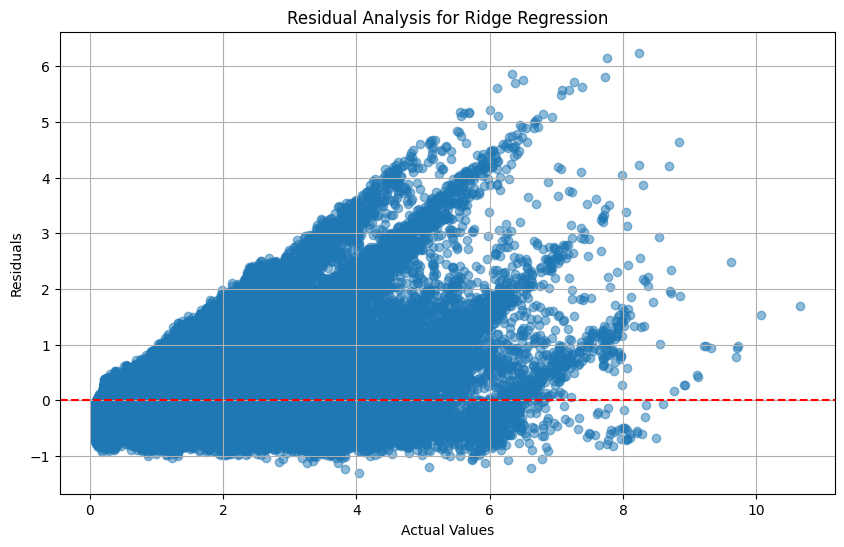

In [ ]:

# Residual Analysis (for Ridge Regression as an example)
residuals = y_test - y_pred_ridge
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis for Ridge Regression')
plt.grid()
plt.show()


## Residual Plot Analysis

### 1. Residual Spread Increases with Actual Values:
- The residuals (errors) are **small and tightly clustered** for lower actual values (near 0–4).  
- As the actual values increase (beyond 4), the residuals **spread wider**, forming a fan-like shape.  
- This indicates **heteroscedasticity**: the variance of the errors increases with the magnitude of the actual values.  

**Implication**:  
- The model struggles to predict large values accurately.  
- Ridge Regression might not fully capture the relationship between the predictors and the target variable for higher ranges.  

### 2. Residuals Are Not Randomly Distributed:
- Ideally, residuals should be **evenly scattered** around the horizontal red line (0 residual).  
- In this plot:  
   - Residuals show **systematic clustering**, especially as the actual values increase.  
   - There are **positive residuals** (above 0) and **negative residuals** (below 0) that form a clear pattern rather than random noise.  

**Implication**:  
- This systematic pattern suggests that the model might be **missing important features or relationships**.  
- The linear assumption of Ridge Regression may not fully represent the **underlying structure** of the data.  

### 3. Outliers:
- There are a few **extreme residuals** (above 5 and below -1) for higher actual values (around 8–10).  
- These outliers may indicate:  
   - **Data points** that the model significantly mispredicts.  
   - Possible **anomalies or noise** in the data.  

**Implication**:  
- Outliers can **distort model performance** and might need to be addressed with robust techniques like **Robust Regression** or outlier removal.  

---

# Possible errors:
- **Heteroscedasticity**: Errors increase as the actual values increase, indicating **unequal variance**.  
- **Systematic Patterns**: Residuals show a **structured, non-random distribution**, which could mean:  
   - Missing features or interactions.  
   - Non-linear relationships not captured by Ridge Regression.  
- **Outliers**: Extreme residuals suggest **misfit** for certain data points.  
